# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(1):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [28]:
import random
import copy
from collections import namedtuple, deque
import torch.optim as optim

BUFFER_SIZE = int(2e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.9             # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR  = 1e-3        # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
OU_MU = 0.2
OU_SIGMA = 0.2
OU_THETA = 0.15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed,learn_every=1,learn_steps=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.total_steps = 0
        self.learn_every = learn_every
        self.learn_steps = learn_steps
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for s, a, r, sp, done in zip(states, actions, rewards, next_states, dones):
                self.memory.add(s, a, r, sp, done)
                
        # Learn, if enough samples are available in memory
        self.total_steps +=1
        if len(self.memory) > BATCH_SIZE and self.total_steps % self.learn_every == 0:
            for _ in range(self.learn_steps):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, noise_scale=0):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        action += self.noise.sample() * noise_scale
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=OU_MU, theta=OU_THETA, sigma=OU_SIGMA):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.priority = deque(maxlen=buffer_size) 
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
 
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""

#         experiences_idx = random.choices(range(len(self.memory)), k=self.batch_size, weights=self.priority)
#         experiences = [self.memory[idx] for idx in experiences_idx]
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [35]:
import matplotlib.pyplot as plt
import time

def ddpg(n_episodes=1000, print_every=100,save_every=500):
    scores_deque = deque(maxlen=100)
    every_score, rolling_avg = [], []
    total_duration = 0
    noise_scale = 1
    for i_episode in range(1, n_episodes+1):
        noise_scale = max(noise_scale * 0.995, 0.1)
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        scores = np.zeros(num_agents) 
        start_time = time.time()

        for t in range(1000):
            actions = agent.act(states,noise_scale)            # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states    
            if np.any(dones):
                break 
        
        scores_deque.append(max(scores))
        every_score.append(max(scores))
        deque_avg = np.mean(scores_deque)
        rolling_avg.append(deque_avg)
        duration = time.time() - start_time
        total_duration += duration
        
        print(f'\rEpisode {i_episode}\tAverage Score: {deque_avg:.4f}\tTime:{duration:.2f} sec.', end="")
        if i_episode % save_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {deque_avg:.4f}\tTime:{total_duration/60:.2f} min.')
        if deque_avg > 0.5 and i_episode >= 100:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {deque_avg:.2f}\tTime:{total_duration:.2f}')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_solved.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_solved.pth')
            return every_score, rolling_avg
            
    return every_score, rolling_avg

In [36]:
%%time
agent = Agent(state_size, action_size, random_seed=33)
every_score, rolling_avg = ddpg(5000)

Episode 100	Average Score: 0.0018	Time:0.36 min.
Episode 200	Average Score: 0.0000	Time:0.75 min.
Episode 300	Average Score: 0.0000	Time:1.14 min.
Episode 400	Average Score: 0.0000	Time:1.54 min.
Episode 500	Average Score: 0.0059	Time:1.97 min.
Episode 600	Average Score: 0.0000	Time:2.36 min.
Episode 700	Average Score: 0.0000	Time:2.75 min.
Episode 800	Average Score: 0.0000	Time:3.15 min.
Episode 900	Average Score: 0.0113	Time:3.60 min.
Episode 1000	Average Score: 0.0405	Time:4.19 min.
Episode 1100	Average Score: 0.0275	Time:4.74 min.
Episode 1200	Average Score: 0.0241	Time:5.32 min.
Episode 1300	Average Score: 0.0393	Time:5.94 min.
Episode 1400	Average Score: 0.0893	Time:6.80 min.
Episode 1500	Average Score: 0.1242	Time:8.04 min.
Episode 1600	Average Score: 0.1559	Time:9.62 min.
Episode 1700	Average Score: 0.3143	Time:12.98 min.
Episode 1800	Average Score: 0.4045	Time:17.49 min.
Episode 1832	Average Score: 0.5198	Time:18.28 sec.
Environment solved in 1832 episodes!	Average Score: 0.52

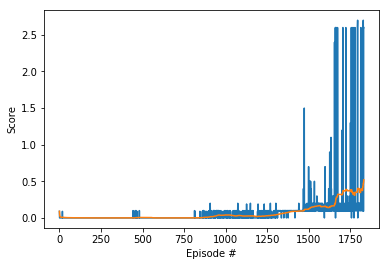

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(every_score)
plt.plot(rolling_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [32]:
%%time
agent = Agent(state_size, action_size, random_seed=33)
every_score, rolling_avg = ddpg(5000)

Episode 100	Average Score: 0.0020	Time:0.37 min.
Episode 200	Average Score: 0.0059	Time:0.82 min.
Episode 300	Average Score: 0.0038	Time:1.24 min.
Episode 400	Average Score: 0.0100	Time:1.71 min.
Episode 500	Average Score: 0.0000	Time:2.11 min.
Episode 600	Average Score: 0.0090	Time:2.57 min.
Episode 700	Average Score: 0.0170	Time:3.11 min.
Episode 800	Average Score: 0.0136	Time:3.57 min.
Episode 900	Average Score: 0.0354	Time:4.15 min.
Episode 1000	Average Score: 0.0246	Time:4.68 min.
Episode 1100	Average Score: 0.0492	Time:5.37 min.
Episode 1200	Average Score: 0.0445	Time:6.00 min.
Episode 1300	Average Score: 0.0872	Time:6.83 min.
Episode 1400	Average Score: 0.0879	Time:7.68 min.
Episode 1500	Average Score: 0.0946	Time:8.53 min.
Episode 1600	Average Score: 0.0951	Time:9.41 min.
Episode 1700	Average Score: 0.0948	Time:10.28 min.
Episode 1800	Average Score: 0.0944	Time:11.16 min.
Episode 1900	Average Score: 0.0942	Time:12.04 min.
Episode 2000	Average Score: 0.0942	Time:12.93 min.
Episo

ValueError: too many values to unpack (expected 2)

In [ ]:
import matplotlib.pyplot as plt
import time

def ddpg_bootstraping(n_episodes=1000, print_every=100,save_every=500,n_boot_step=2):
    scores_deque = deque(maxlen=100)
    every_score, rolling_avg = [], []
    total_duration = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        scores = np.zeros(num_agents) 
        start_time = time.time()
        
        bs_deque = deque(maxlen=n_boot_step)                   #bootstrap_deque
        for t in range(1000):
            actions = agent.act(states)                        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards
            
            bs_deque.append([states, actions, rewards])
            if len(bs_deque) == n_boot_step and not np.any(dones):
                state0 = bs_deque[0][0]
                action0= bs_deque[0][1]
                cum_r = np.zeros(num_agents) 
                disc = 1
                for i in range(n_boot_step):
                    cum_r+= np.array(bs_deque[i][2])*disc
                    disc *= GAMMA
                for s, a, r, sp, done in zip(state0, action0, cum_r, next_states, dones):
                    agent.add_sample(s, a, r, sp, done)
                agent.update()
                
            if np.any(dones):
                #add last steps of bs_deque
                for i in range(n_boot_step):
                    state0 = bs_deque[i][0]
                    action0= bs_deque[i][1]
                    cum_r = np.zeros(num_agents) 
                    disc = 1
                    max_step = min(len(bs_deque)-i,n_boot_step-i)
                    for j in range(max_step):
                        cum_r+= np.array(bs_deque[i+j][2])*disc
                        disc *= GAMMA
                    for s, a, r, sp, done in zip(state0, action0, cum_r, next_states, dones):
                        agent.add_sample(s, a, r, sp, done)
                    agent.update() 
                break 
                
            states = next_states
        
        
        scores_deque.append(max(scores))
        every_score.append(max(scores))
        deque_avg = np.mean(scores_deque)
        rolling_avg.append(deque_avg)
        duration = time.time() - start_time
        total_duration += duration
        
        print(f'\rEpisode {i_episode}\tAverage Score: {deque_avg:.4f}\tTime:{duration:.2f} sec.', end="")
        if i_episode % save_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {deque_avg:.4f}\tTime:{total_duration/60:.2f} min.')
        if deque_avg > 0.5 and i_episode >= 100:
            print(f'Environment solved in {i_episode} episodes!\tAverage Score: {deque_avg:.2f}\tTime:{total_duration:.2f}')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            return every_score
            
    return every_score, rolling_avg

In [ ]:
#https://github.com/the-computer-scientist/OpenAIGym/blob/master/PrioritizedExperienceReplayInOpenAIGym.ipynb
#PER https://arxiv.org/abs/1511.05952
class PrioritizedReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed, uniform=False):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.priorities = deque(maxlen=buffer_size)  # internal memory (deque)
        self.max_prior = 1
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
        self.seed = random.seed(seed)
        self.uniform = uniform
        self.probs = None
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.priorities.append(self.max_prior)
        
    def calc_probabilities(self, alpha=0.7):
        #alpha 0 for uniform distribution of probabilities = no priority
        scaled_priorities = np.array(self.priorities) ** alpha
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        self.probs = sample_probabilities
    
    def get_importance(self, probabilities):
        importance = 1/len(self.memory) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized**self.beta
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        ws = None if self.uniform else self.probs
        experiences_idx = random.choices(range(len(self.memory)), k=self.batch_size, weights=self.probs)
        experiences = [self.memory[idx] for idx in experiences_idx]
        
        states = torch.from_numpy(np.stack([e.states for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.stack([e.actions for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.stack([e.rewards for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_states for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.stack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        rewards.unsqueeze_(2)
        dones.unsqueeze_(2)
        
        if not self.uniform:
            importance = torch.from_numpy(self.get_importance(self.probs[experiences_idx])).float().to(device)
            return (states, actions, rewards, next_states, dones), importance, experiences_idx
        else:
            return (states, actions, rewards, next_states, dones), [], []

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    def set_priorities(self, indices, errors, offset=1e-6):
        for i,e in zip(indices, errors):
            self.priorities[i] = (abs(e) + offset).item()
            
    def calc_max_prior(self):
        self.max_prior = max(self.priorities)